In [ ]:
from typing import List
import numpy as np
import torch.cuda
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import copy
import nashpy as nash

from utils.logger import Logger
from utils.io_utils import save_code
from utils.utils import model_comparison,distribution_comparison, generate_outputs_from_distribution
from utils.plot import two_action_prob_plot

from algorithm_single_state import RewardModel, MaximumLikelihoodEstimator,PolicyGradientOptimizer,DirectPreferenceOptimizer, SelfPlayPreferenceOptimizer, SPPOClosedForm
from policy import UniformPolicyModel,PolicyModel,Ref_PolicyModel
from utils.collect_data import collect_preference_data, NonMonotonicScalarToVectorNN, check_data_consistency, check_cyclic_order

In [2]:
from datetime import datetime

np.random.seed(5)

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
log_dir = f"./logs/test_{current_time}"
save_code(log_dir)

logger = Logger(log_dir)
writer = SummaryWriter(log_dir)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

In [3]:
state_dim = 1
actions = [-10,0,10]

### Collect data

In [4]:
torch.manual_seed(5)
feature_func = NonMonotonicScalarToVectorNN()
pref_dataset, p_list = collect_preference_data(actions,60,feature_func)

In [5]:
action_to_index = {-10: 0, 0: 1, 10: 2}

states = torch.cat([torch.tensor(x.state) for x in pref_dataset], dim=0)

positive_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_1] if x.pref == 1 else action_to_index[x.action_0]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

negative_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_0] if x.pref == 1 else action_to_index[x.action_1]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

print(f"states: {states}")
print(f"positive_actions: {positive_actions}")
print(f"negative_actions: {negative_actions}")

# check transition and consistency
print(f"check transition: {check_cyclic_order(p_list,actions)}")
print(f"check data consistency: {check_data_consistency(pref_dataset)}")

states: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
positive_actions: tensor([0, 1, 2, 1, 2, 2, 0, 0, 0, 2, 1, 1, 2, 1, 0, 1, 0, 2, 0, 0, 1, 2, 2, 2,
        2, 2, 1, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 1, 1, 2,
        0, 1, 0, 0, 1, 0, 2, 2, 1, 2, 1, 0])
negative_actions: tensor([1, 0, 1, 2, 1, 1, 2, 1, 2, 0, 2, 2, 1, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0, 1,
        1, 1, 0, 1, 2, 0, 0, 0, 2, 1, 2, 1, 0, 1, 1, 1, 2, 2, 0, 2, 1, 2, 0, 1,
        1, 2, 2, 2, 0, 2, 1, 1, 2, 0, 0, 1])
check transition: (True, ('-10', '0', '10'))
check data consistency: 0.8


## Nash equilibrium

In [6]:
# compute nash equilibrium

A = np.array([
    [0.5, 0.1, 0.8],
    [0.9, 0.5, 0.1],
    [0.2, 0.9, 0.5]
])


game = nash.Game(p_list, -p_list)

#game = nash.Game(A, -A)
equilibria = list(game.support_enumeration())

for eq in equilibria:
    print("Nash equilibrium of this game: ", eq[0])  

Nash equilibrium of this game:  [0.51859606 0.09025695 0.39114699]


In [7]:
# We use action 0 and action 1 to plot the scatter plot
nash_point= [eq[0][0],eq[0][1]]
nash_point

[0.5185960617933865, 0.09025694564670378]

## 1 state 1 action

### RLHF

In [ ]:
learned_reward_model = RewardModel(
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
)

In [9]:
mle_learner = MaximumLikelihoodEstimator(
    actions,
    learned_reward_model,
    learning_rate=1e-4,
    batch_size=64,
    logger=logger,
)

In [10]:
import time  # for seed

torch.manual_seed(time.time())
mle_learner.optimize(
    states, positive_actions, negative_actions, num_epochs=20
)

2024-11-26 20:11:46,705 - /home/hanwen/policy_optimization/exp/algorithm.py[line:123] - INFO: [Reward] Epoch 0 loss: 0.6915 acc: 0.52
2024-11-26 20:11:46,720 - /home/hanwen/policy_optimization/exp/algorithm.py[line:123] - INFO: [Reward] Epoch 2 loss: 0.6910 acc: 0.52
2024-11-26 20:11:46,736 - /home/hanwen/policy_optimization/exp/algorithm.py[line:123] - INFO: [Reward] Epoch 4 loss: 0.6905 acc: 0.52
2024-11-26 20:11:46,751 - /home/hanwen/policy_optimization/exp/algorithm.py[line:123] - INFO: [Reward] Epoch 6 loss: 0.6902 acc: 0.52
2024-11-26 20:11:46,767 - /home/hanwen/policy_optimization/exp/algorithm.py[line:123] - INFO: [Reward] Epoch 8 loss: 0.6898 acc: 0.55
2024-11-26 20:11:46,782 - /home/hanwen/policy_optimization/exp/algorithm.py[line:123] - INFO: [Reward] Epoch 10 loss: 0.6896 acc: 0.55
2024-11-26 20:11:46,798 - /home/hanwen/policy_optimization/exp/algorithm.py[line:123] - INFO: [Reward] Epoch 12 loss: 0.6894 acc: 0.55
2024-11-26 20:11:46,813 - /home/hanwen/policy_optimization/e

In [11]:
ref_policy = UniformPolicyModel(
    action_num=len(actions),
    device=device
).to(device)

ref_policy2 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.7,0.2,0.1]]),device).to(device)

ref_policy3 = Ref_PolicyModel(
    len(actions),torch.tensor([[1.0,0.0,0.0]]),device).to(device)

ref_policy4 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.1,0.3,0.6]]),device).to(device)

print(ref_policy(torch.tensor([[0.0]])))
print(ref_policy2(torch.tensor([[0.0]])))
print(ref_policy3(torch.tensor([[0.0]])))
print(ref_policy4(torch.tensor([[0.0]])))

tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([[0.7000, 0.2000, 0.1000]], device='cuda:0')
tensor([[1., 0., 0.]], device='cuda:0')
tensor([[0.1000, 0.3000, 0.6000]], device='cuda:0')


In [12]:
states = torch.zeros(len(pref_dataset), 1, dtype=torch.float32).to(device) 
states.shape

torch.Size([60, 1])

In [13]:
# pg
policy = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [14]:
policy_optimizer = PolicyGradientOptimizer(
    policy=policy,
    reward_model=learned_reward_model,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    logger=logger,
    nash_point = nash_point
)

/home/hanwen/policy_optimization/exp/utils/utils.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
2024-11-26 20:11:47,778 - /home/hanwen/policy_optimization/exp/algorithm.py[line:204] - INFO: [Policy] Epoch 0 loss: -0.2011 reward: 0.2011 ref_reward: 0.1991 improvement: 0.97%
2024-11-26 20:11:49,335 - /home/hanwen/policy_optimization/exp/algorithm.py[line:204] - INFO: [Policy] Epoch 2 loss: -0.2042 reward: 0.2042 ref_reward: 0.1991 improvement: 2.55%
2024-11-26 20:11:50,896 - /home/hanwen/policy_optimization/exp/algorithm.py[line:204] - INFO: [Policy] Epoch 4 loss: -0.2073 reward: 0.2073 ref_reward: 0.1991 improvement: 4.11%
2024-11-26 20:11:52,457 - /home/hanwen/policy_optimization/exp/algorithm.py[line:204] - INFO: [Policy] Epoch 6 loss: -0.2103 reward: 0.2103

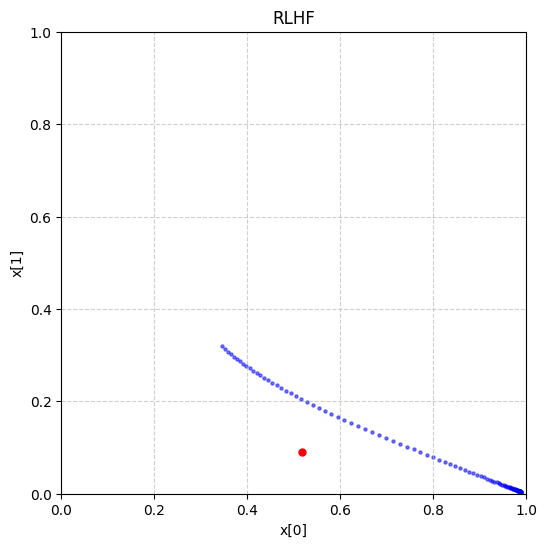

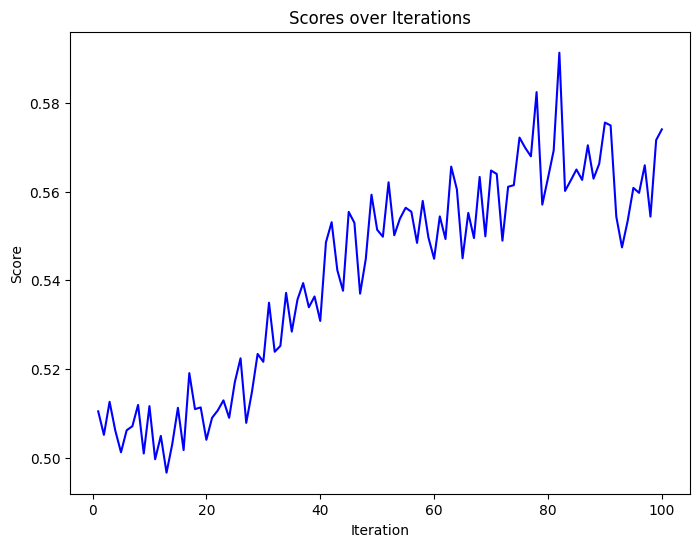

In [15]:
policy_optimizer.optimize(states=states, p_list=p_list, num_epochs=100)


In [16]:
state_0 = torch.tensor([0.0], dtype=torch.float32).to(device)
action_0 = torch.tensor([1,0,0], dtype=torch.float32).to(device)
action_1 = torch.tensor([0,0,1], dtype=torch.float32).to(device)
action_2 = torch.tensor([0,1,0], dtype=torch.float32).to(device)
print(learned_reward_model(state_0,action_0))
print(learned_reward_model(state_0,action_1))
print(learned_reward_model(state_0,action_2))

tensor([0.3088], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.1832], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.0883], device='cuda:0', grad_fn=<ViewBackward0>)


In [17]:
# output the probabilities of each action from the learned policy
test_state = torch.tensor([[0.0]], dtype=torch.float32).to(device)  

with torch.no_grad():
    action_probs = policy(test_state)
    action_probs = action_probs.cpu().numpy()[0]  

actions = [-10, 0, 10]  
for action, prob in zip(actions, action_probs):
    print(f"P(action={action}) = {prob:.3f}")

# output the probabilities of each action from the reference policy
ref_probs = ref_policy(test_state).cpu().numpy()[0]
print("\nUniform policy probabilities:")
for action, prob in zip(actions, ref_probs):
    print(f"P(action={action}) = {prob:.3f}")

P(action=-10) = 0.989
P(action=0) = 0.004
P(action=10) = 0.007

Uniform policy probabilities:
P(action=-10) = 0.333
P(action=0) = 0.333
P(action=10) = 0.333


In [18]:
# compare the learned policy with the reference policy
score = model_comparison(policy, ref_policy,p_list)
print(f"\nRLHF model and base model comparison score: {score:.3f}")


RLHF model and base model comparison score: 0.564


### DPO

In [19]:
policy_dpo_1 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_4 = PolicyModel(   
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [20]:
dpo_optimizer_1 = DirectPreferenceOptimizer(
    policy=policy_dpo_1,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_2 = DirectPreferenceOptimizer(
    policy=policy_dpo_2,
    ref_policy=ref_policy2,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_3 = DirectPreferenceOptimizer(
    policy=policy_dpo_3,
    ref_policy=ref_policy3,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_4 = DirectPreferenceOptimizer(
    policy=policy_dpo_4,
    ref_policy=ref_policy4,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

2024-11-26 20:12:30,980 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 0 loss: 0.6929 grad norm: 0.0306 
2024-11-26 20:12:31,478 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 5 loss: 0.6908 grad norm: 0.0199 
2024-11-26 20:12:31,990 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 10 loss: 0.6896 grad norm: 0.0130 
2024-11-26 20:12:32,492 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 15 loss: 0.6890 grad norm: 0.0064 
2024-11-26 20:12:32,990 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 20 loss: 0.6888 grad norm: 0.0020 
2024-11-26 20:12:33,485 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 25 loss: 0.6889 grad norm: 0.0043 
2024-11-26 20:12:33,985 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 30 loss: 0.6889 grad n

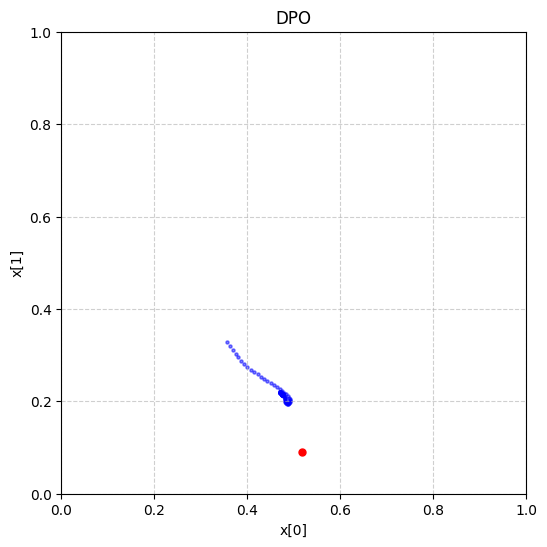

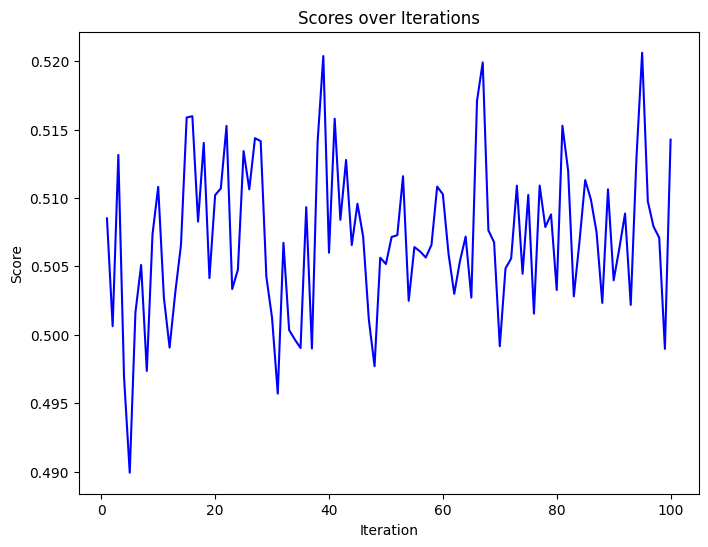

2024-11-26 20:12:41,261 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 0 loss: 0.7380 grad norm: 0.1020 
2024-11-26 20:12:41,756 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 5 loss: 0.7278 grad norm: 0.0941 
2024-11-26 20:12:42,258 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 10 loss: 0.7191 grad norm: 0.0865 
2024-11-26 20:12:42,760 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 15 loss: 0.7118 grad norm: 0.0829 
2024-11-26 20:12:43,264 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 20 loss: 0.7053 grad norm: 0.0780 
2024-11-26 20:12:43,764 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 25 loss: 0.6997 grad norm: 0.0688 
2024-11-26 20:12:44,263 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 30 loss: 0.6952 grad n

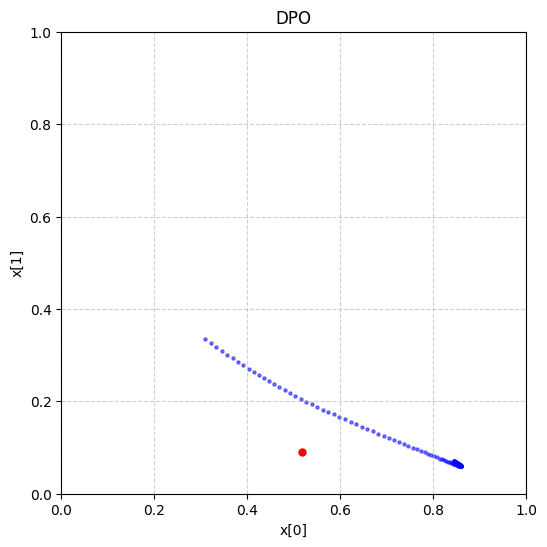

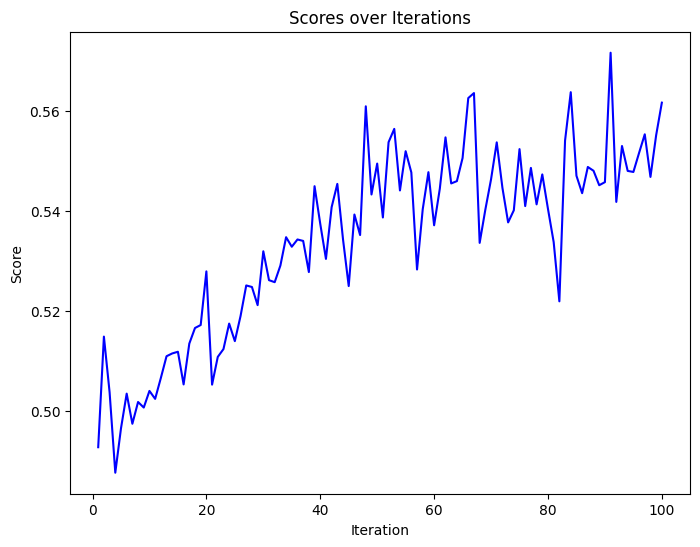

2024-11-26 20:12:59,337 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 0 loss: 0.8150 grad norm: 0.1591 
2024-11-26 20:13:05,192 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 5 loss: 0.7983 grad norm: 0.1631 
2024-11-26 20:13:11,484 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 10 loss: 0.7830 grad norm: 0.1659 
2024-11-26 20:13:19,849 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 15 loss: 0.7689 grad norm: 0.1673 
2024-11-26 20:13:27,466 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 20 loss: 0.7558 grad norm: 0.1711 
2024-11-26 20:13:35,556 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 25 loss: 0.7432 grad norm: 0.1700 
2024-11-26 20:13:44,156 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 30 loss: 0.7311 grad n

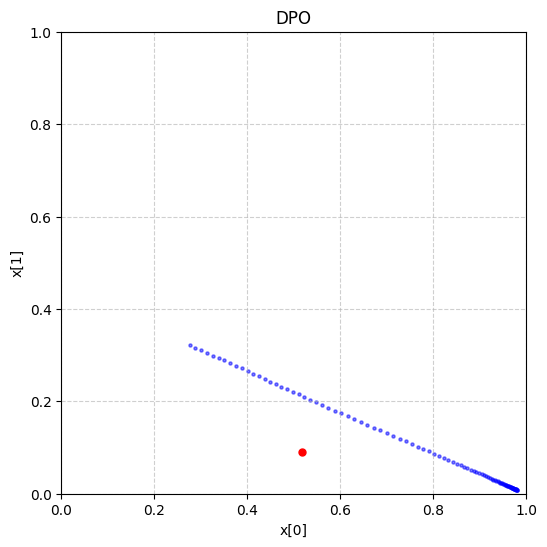

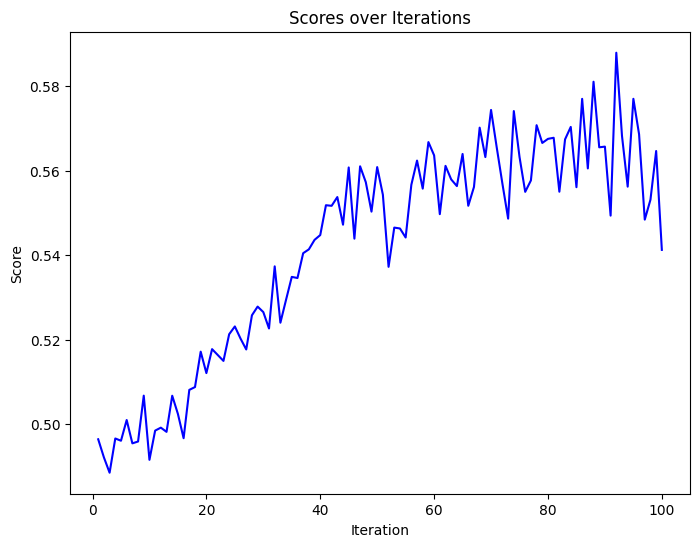

2024-11-26 20:15:15,636 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 0 loss: 0.6986 grad norm: 0.0507 
2024-11-26 20:15:21,513 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 5 loss: 0.6947 grad norm: 0.0439 
2024-11-26 20:15:26,863 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 10 loss: 0.6917 grad norm: 0.0347 
2024-11-26 20:15:30,214 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 15 loss: 0.6898 grad norm: 0.0219 
2024-11-26 20:15:33,345 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 20 loss: 0.6890 grad norm: 0.0072 
2024-11-26 20:15:36,494 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 25 loss: 0.6890 grad norm: 0.0093 
2024-11-26 20:15:39,611 - /home/hanwen/policy_optimization/exp/algorithm.py[line:332] - INFO: [Policy] Epoch: 30 loss: 0.6890 grad n

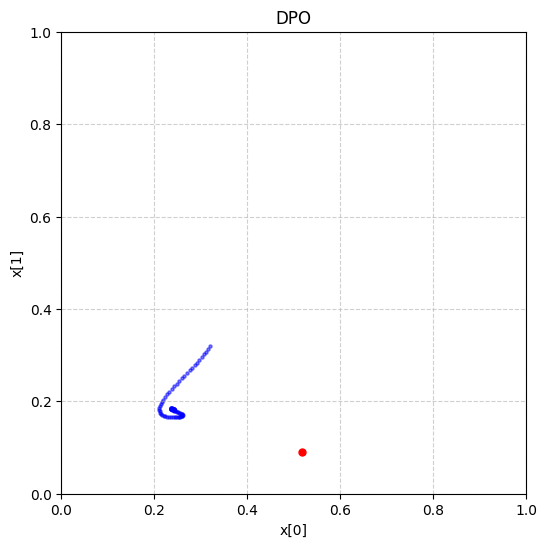

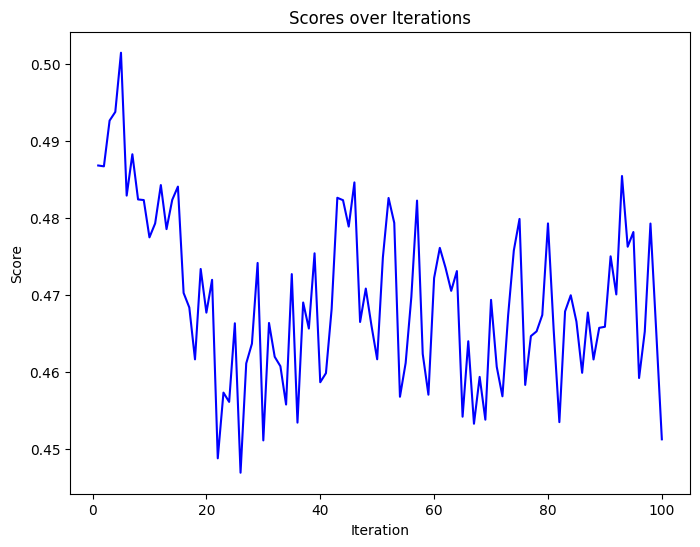

In [21]:
dpo_optimizer_1.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [0.33,0.33,0.33]

dpo_optimizer_2.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [0.7,0.2,0.1]

dpo_optimizer_3.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [1.0,0.0,0.0]

dpo_optimizer_4.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [0.1,0.3,0.6]

In [22]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_dpo_1(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
# compare the learned policy with the reference policy
score = model_comparison(policy_dpo_1, ref_policy,p_list)
print(f"\nDPO model and base model comparison score: {score:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_2(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_dpo_2, ref_policy2,p_list)
print(f"\nDPO model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_3(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_dpo_3, ref_policy3,p_list)
print(f"\nDPO model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_4(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_dpo_4, ref_policy4,p_list)
print(f"\nDPO model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.474
P(action=0) = 0.215
P(action=10) = 0.310

DPO model and base model comparison score: 0.518

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.844
P(action=0) = 0.072
P(action=10) = 0.085

DPO model and base model comparison score: 0.534

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 0.980
P(action=0) = 0.008
P(action=10) = 0.012

DPO model and base model comparison score: 0.497

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.241
P(action=0) = 0.180
P(action=10) = 0.578

DPO model and base model comparison score: 0.489


### SPPO

In [23]:
policy_sppo_1 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_4 = PolicyModel(   
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [24]:
chosen_probs = torch.tensor([x.chosen_probs for x in pref_dataset], dtype=torch.float32).to(device)

In [25]:
sppo_optimizer_1 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_1,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_2 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_2,
    ref_policy=ref_policy2,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_3 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_3,
    ref_policy=ref_policy3,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_4 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_4,
    ref_policy=ref_policy4,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

In [26]:
sppo_optimizer_1.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=300
)

sppo_optimizer_2.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=300
)

sppo_optimizer_3.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=300
)

sppo_optimizer_4.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=300
)

2024-11-26 20:16:40,753 - /home/hanwen/policy_optimization/exp/algorithm.py[line:456] - INFO: [Policy] Epoch: 0 loss: 0.0013 grad norm: 0.0392 
2024-11-26 20:16:49,148 - /home/hanwen/policy_optimization/exp/algorithm.py[line:456] - INFO: [Policy] Epoch: 5 loss: 0.0001 grad norm: 0.0071 
2024-11-26 20:16:56,840 - /home/hanwen/policy_optimization/exp/algorithm.py[line:456] - INFO: [Policy] Epoch: 10 loss: 0.0002 grad norm: 0.0093 
2024-11-26 20:17:04,594 - /home/hanwen/policy_optimization/exp/algorithm.py[line:456] - INFO: [Policy] Epoch: 15 loss: 0.0002 grad norm: 0.0102 
2024-11-26 20:17:12,266 - /home/hanwen/policy_optimization/exp/algorithm.py[line:456] - INFO: [Policy] Epoch: 20 loss: 0.0000 grad norm: 0.0016 
2024-11-26 20:17:19,725 - /home/hanwen/policy_optimization/exp/algorithm.py[line:456] - INFO: [Policy] Epoch: 25 loss: 0.0001 grad norm: 0.0050 
2024-11-26 20:17:27,237 - /home/hanwen/policy_optimization/exp/algorithm.py[line:456] - INFO: [Policy] Epoch: 30 loss: 0.0000 grad n

KeyboardInterrupt: 

In [ ]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_sppo_1(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
score = model_comparison(policy_sppo_1, ref_policy,p_list)
print(f"\nSPPO model and base model comparison score: {score:.3f}")


with torch.no_grad():
    action_probs = policy_sppo_2(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_sppo_2, ref_policy2,p_list)
print(f"\nSPPO model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_3(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_sppo_3, ref_policy3,p_list)
print(f"\nSPPO model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_4(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_sppo_4, ref_policy4,p_list)
print(f"\nSPPO model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.353
P(action=0) = 0.251
P(action=10) = 0.395

SPPO model and base model comparison score: 0.499

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.453
P(action=0) = 0.269
P(action=10) = 0.278

SPPO model and base model comparison score: 0.485

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 0.371
P(action=0) = 0.319
P(action=10) = 0.309

SPPO model and base model comparison score: 0.444

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.228
P(action=0) = 0.323
P(action=10) = 0.449

SPPO model and base model comparison score: 0.523


### SPPO Closed-form solution

In [ ]:
sppo_closed_form_1 = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_2 = SPPOClosedForm( 
    actions,                      
    score_ref_model = ref_policy,             
    ref_policy=ref_policy2,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_3 = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy3,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_4 = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy4,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

2024-11-26 15:37:18,974 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 0: ref_distribution = tensor([0.3333, 0.3333, 0.3333], device='cuda:0'), new_distribution = tensor([0.3336, 0.3334, 0.3330], device='cuda:0')


2024-11-26 15:37:19,040 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 1: ref_distribution = tensor([0.3336, 0.3334, 0.3330], device='cuda:0'), new_distribution = tensor([0.3338, 0.3335, 0.3327], device='cuda:0')
2024-11-26 15:37:19,095 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 2: ref_distribution = tensor([0.3338, 0.3335, 0.3327], device='cuda:0'), new_distribution = tensor([0.3340, 0.3336, 0.3324], device='cuda:0')
2024-11-26 15:37:19,149 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 3: ref_distribution = tensor([0.3340, 0.3336, 0.3324], device='cuda:0'), new_distribution = tensor([0.3342, 0.3337, 0.3321], device='cuda:0')
2024-11-26 15:37:19,203 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 4: ref_distribution = tensor([0.3342, 0.3337, 0.3321], device='cuda:0'), new_distribution = tensor([0.3344, 0.3338, 0.3318], device='cuda:0')
2024-11-26 15:37

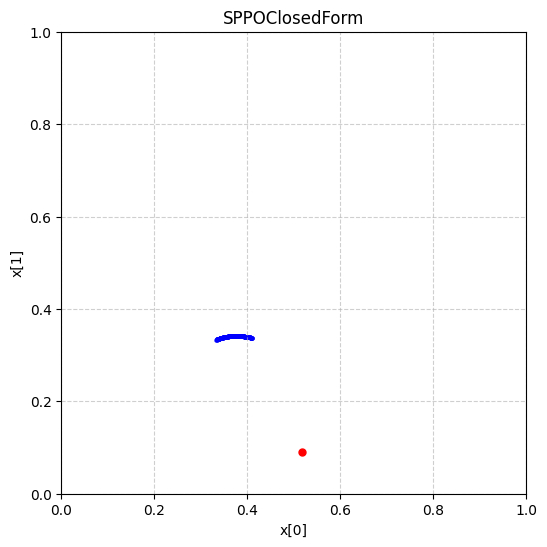

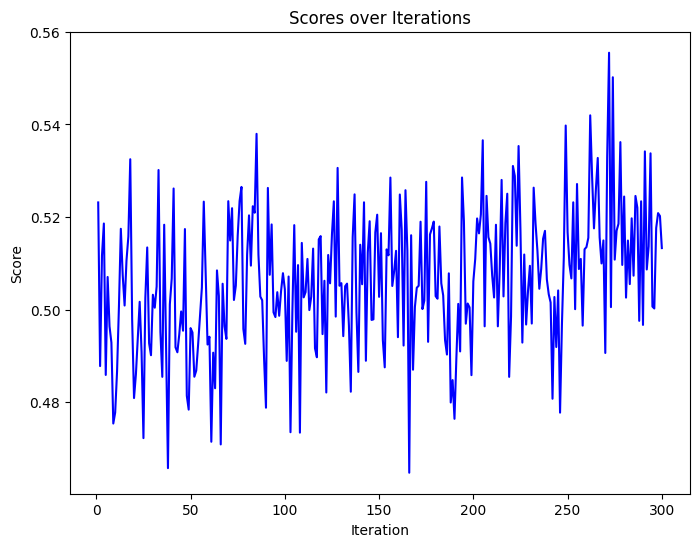

2024-11-26 15:37:34,234 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 0: ref_distribution = tensor([0.7000, 0.2000, 0.1000], device='cuda:0'), new_distribution = tensor([0.7003, 0.1997, 0.1000], device='cuda:0')
2024-11-26 15:37:34,280 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 1: ref_distribution = tensor([0.7003, 0.1997, 0.1000], device='cuda:0'), new_distribution = tensor([0.7006, 0.1994, 0.0999], device='cuda:0')
2024-11-26 15:37:34,328 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 2: ref_distribution = tensor([0.7006, 0.1994, 0.0999], device='cuda:0'), new_distribution = tensor([0.7009, 0.1991, 0.0999], device='cuda:0')
2024-11-26 15:37:34,374 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 3: ref_distribution = tensor([0.7009, 0.1991, 0.0999], device='cuda:0'), new_distribution = tensor([0.7013, 0.1988, 0.0999], device='cuda:0')
2024-11-26 15:37

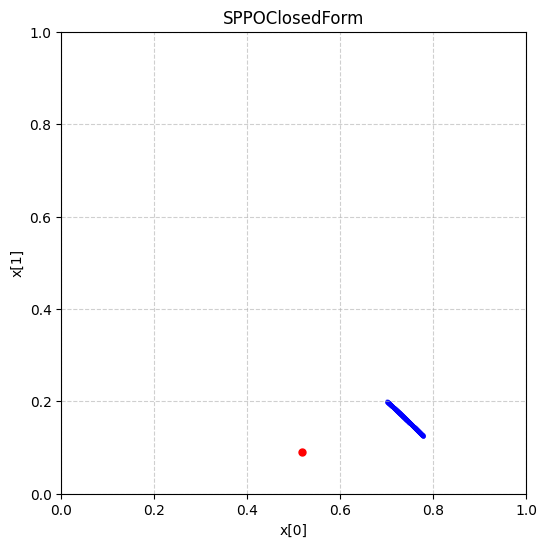

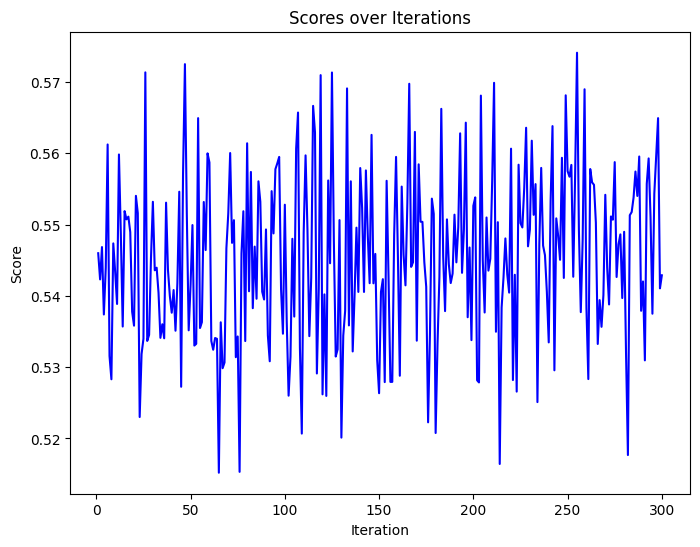

2024-11-26 15:37:49,951 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 0: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-26 15:37:49,997 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 1: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-26 15:37:50,043 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 2: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-26 15:37:50,088 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 3: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-26 15:37:50,134 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 4: ref_d

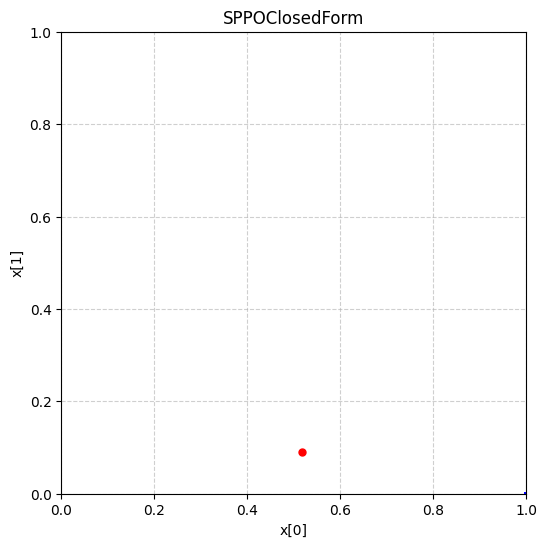

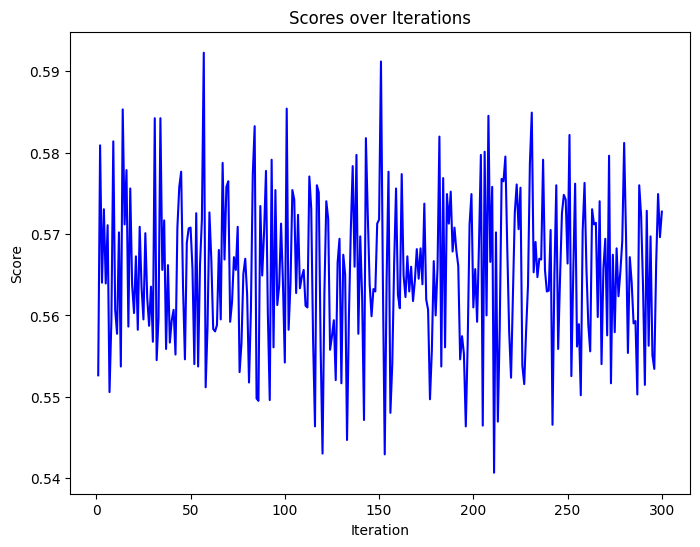

2024-11-26 15:38:04,381 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 0: ref_distribution = tensor([0.1000, 0.3000, 0.6000], device='cuda:0'), new_distribution = tensor([0.1000, 0.3005, 0.5994], device='cuda:0')
2024-11-26 15:38:04,428 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 1: ref_distribution = tensor([0.1000, 0.3005, 0.5994], device='cuda:0'), new_distribution = tensor([0.1001, 0.3011, 0.5989], device='cuda:0')
2024-11-26 15:38:04,474 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 2: ref_distribution = tensor([0.1001, 0.3011, 0.5989], device='cuda:0'), new_distribution = tensor([0.1001, 0.3016, 0.5983], device='cuda:0')
2024-11-26 15:38:04,520 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 3: ref_distribution = tensor([0.1001, 0.3016, 0.5983], device='cuda:0'), new_distribution = tensor([0.1002, 0.3021, 0.5977], device='cuda:0')
2024-11-26 15:38

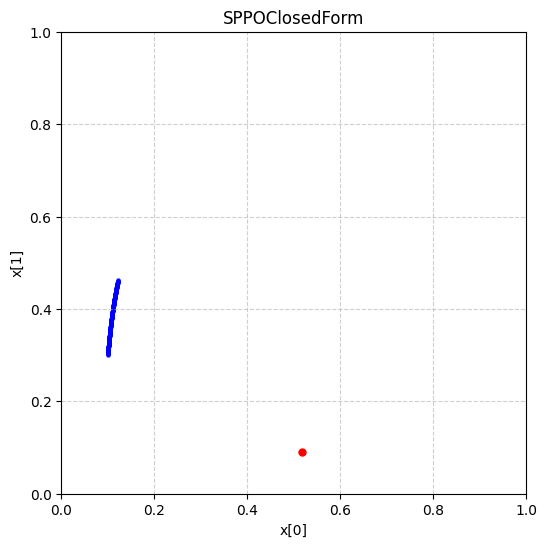

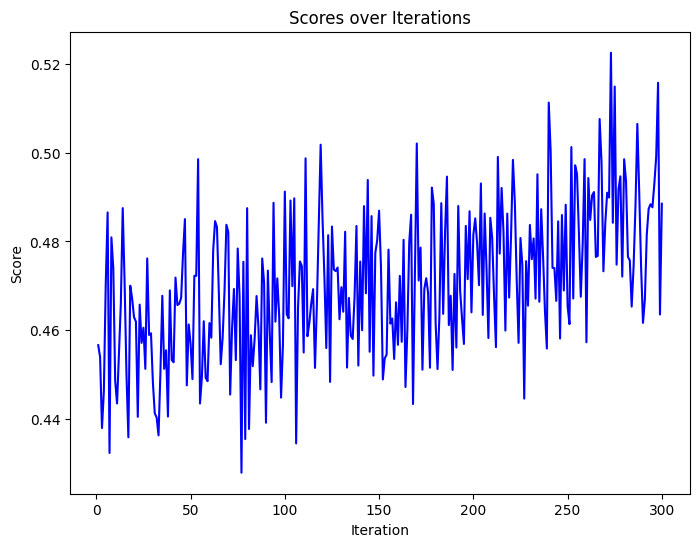

In [ ]:
sppo_distribution_1 = sppo_closed_form_1.optimize(
    p_list=p_list,
    num_iters=300
)   

sppo_distribution2 = sppo_closed_form_2.optimize(
    p_list=p_list,
    num_iters=300
)

sppo_distribution3 = sppo_closed_form_3.optimize(
    p_list=p_list,
    num_iters=300
)

sppo_distribution4 = sppo_closed_form_4.optimize(
    p_list=p_list,
    num_iters=300
)

## 3 states 6 actions

In [27]:
state_num = 3
action_num = 6

### Collect data

In [66]:
import numpy as np

def get_state_p_list(action_num, transitivity_rate, seed=42):
    np.random.seed(seed)
    
    actions = np.arange(action_num)
    p_list = np.zeros((action_num, action_num))
    np.fill_diagonal(p_list, 0.5)  # Self-preference is 0.5
    
    # Select actions in cycle
    cycle_num = int(action_num * transitivity_rate)
    in_cycle_actions = np.random.choice(actions, cycle_num, replace=False)
    
    # Actions not in cycle
    non_cycle_actions = [a for a in actions if a not in in_cycle_actions]
    
    # 1. Form a cycle
    for i in range(len(in_cycle_actions)):
        current = in_cycle_actions[i]
        next_action = in_cycle_actions[(i + 1) % len(in_cycle_actions)]  # Loop back to start
        p_list[current][next_action] = np.round(np.random.uniform(0.7, 1), 2)
        p_list[next_action][current] = np.round(1 - p_list[current][next_action], 2)
    
    # 2. Assign preferences for non-adjacent pairs in cycle
    for i in range(len(in_cycle_actions)):
        for j in range(i + 2, len(in_cycle_actions)):
            a, b = in_cycle_actions[i], in_cycle_actions[j]
            if p_list[a][b] == 0:
                p_list[a][b] = np.round(np.random.uniform(0.7, 1), 2)
                p_list[b][a] = np.round(1 - p_list[a][b], 2)
    
    # 3. Assign preferences within non-cycle actions (linear transitivity)
    for i in range(len(non_cycle_actions)):
        for j in range(i + 1, len(non_cycle_actions)):
            a1, a2 = non_cycle_actions[i], non_cycle_actions[j]
            p_list[a1][a2] = np.round(np.random.uniform(0.7, 1), 2)
            p_list[a2][a1] = np.round(1 - p_list[a1][a2], 2)
    
    # 4. Assign preferences between cycle and non-cycle actions
    for cycle_a in in_cycle_actions:
        for non_cycle_a in non_cycle_actions:
            # In cycle actions are always better than non-cycle actions
            p_list[cycle_a][non_cycle_a] = np.round(np.random.uniform(0.7, 1), 2)
            p_list[non_cycle_a][cycle_a] = np.round(1 - p_list[cycle_a][non_cycle_a], 2)
    

    return p_list, in_cycle_actions



# generate p_list with different transitivity rates
# p_list, in_cycle_actions = get_state_p_list(action_num=6, transitivity_rate=0, seed=42)
# print("\nCycle actions:", in_cycle_actions)
# print(f"p_list(transitivity rate = {0}):")
# print(p_list)

# p_list, in_cycle_actions = get_state_p_list(action_num=6, transitivity_rate=0.5, seed=42)
# print("\nCycle actions:", in_cycle_actions)
# print(f"p_list(transitivity rate = {0.5}):")
# print(p_list)

# p_list, in_cycle_actions = get_state_p_list(action_num=6, transitivity_rate=1, seed=42)
# print("\nCycle actions:", in_cycle_actions)
# print(f"p_list(transitivity rate = {1}):")
# print(p_list)

In [60]:
def get_p_list(state_num, action_num, transitivity_rate, master_seed=42):
    rng = np.random.default_rng(master_seed)
    
    p_list = np.zeros((state_num, action_num, action_num))
    for i in range(state_num):
        seed = rng.integers(0, 1e6)
        p_list[i], in_cycle_actions = get_state_p_list(action_num, transitivity_rate, seed=seed)
        # print(f"\nState {i} cycle actions:", in_cycle_actions)
    return p_list

multi_state_p_list_0 = get_p_list(state_num=3, action_num=6, transitivity_rate=0, master_seed=42)
multi_state_p_list_50 = get_p_list(state_num=3, action_num=6, transitivity_rate=0.5, master_seed=42)
multi_state_p_list_100 = get_p_list(state_num=3, action_num=6, transitivity_rate=1, master_seed=42)
# print("\nGenerated p_list:")
# print(multi_state_p_list_50)
    

In [61]:
import collections


Transition = collections.namedtuple(
    "Transition", ["state", "action_0", "action_1", "pref", "chosen_probs"]
)

def collect_preference_data_multi_state(
    state_num: int,
    action_num: int,
    sample_size: int,
    p_list: np.ndarray,
) -> List[Transition]:
    
    
    pref_dataset = []
     
    for i in range(state_num):
        cur_state = i
        actions = np.arange(action_num * i, action_num * (i + 1)) 
            
        for j in range(sample_size):
            idx_one, idx_two = np.random.choice(len(actions), 2, replace=False)
            action_one = actions[idx_one]
            action_two = actions[idx_two]
        
            bernoulli_param = p_list[i][idx_one][idx_two]
        
            if np.random.random() < bernoulli_param:  
                transition = Transition(
                    cur_state, action_one, action_two, 0, p_list[i][idx_one][idx_two]
                )
            else:
                transition = Transition(
                    cur_state, action_two, action_one, 1, p_list[i][idx_two][idx_one]
                )
            pref_dataset.append(transition)

           
    return pref_dataset,p_list

In [62]:
pref_dataset_0, _ = collect_preference_data_multi_state(state_num=3, action_num=6, sample_size=100, p_list=multi_state_p_list_0)
pref_dataset_50, _ = collect_preference_data_multi_state(state_num=3, action_num=6, sample_size=100, p_list=multi_state_p_list_50)
pref_dataset_100, _ = collect_preference_data_multi_state(state_num=3, action_num=6, sample_size=100, p_list=multi_state_p_list_100)
len(pref_dataset_0), len(pref_dataset_50), len(pref_dataset_100)

(300, 300, 300)

In [63]:
def check_data_consistency(pref_dataset):
    consistent = 0
    total = len(pref_dataset)
    
    for t in pref_dataset:
      
        if (t.chosen_probs > 0.5):
            consistent += 1
    
    return consistent / total

In [64]:
check_data_consistency(pref_dataset_0), check_data_consistency(pref_dataset_50), check_data_consistency(pref_dataset_100)

(0.88, 0.8466666666666667, 0.8733333333333333)

### Nash equilibrium 

In [ ]:
# compute nash equilibrium

A = np.array([
    [0.5, 0.1, 0.8],
    [0.9, 0.5, 0.1],
    [0.2, 0.9, 0.5]
])


game_0 = nash.Game(p_list, -p_list)

#game = nash.Game(A, -A)
equilibria = list(game.support_enumeration())

for eq in equilibria:
    print("Nash equilibrium of this game: ", eq[0])  

Nash equilibrium of this game:  [0.24752475 0.37623762 0.         0.37623762 0.         0.        ]


In [ ]:
# We use action 0 and action 1 to plot the scatter plot
nash_point= [eq[0][0],eq[0][1]]
nash_point

### RLHF

### DPO

### SPPO

### SPPO closed-form solution

## Summary

In [ ]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    
    print("\n ##### Learned policy probabilities of RLHF: #####")
    action_probs = policy(test_state)
    print("\nLearned policy probabilities(RLHF):")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score = model_comparison(policy, ref_policy,p_list)
    print(f"\nRLHF model and base model comparison score: {score:.3f}")


 ##### Learned policy probabilities of RLHF: #####

Learned policy probabilities(RLHF):
P(action=-10) = 0.987
P(action=0) = 0.007
P(action=10) = 0.006

RLHF model and base model comparison score: 0.554


In [ ]:
print("\n ##### Learned policy probabilities of DPO: #####")
with torch.no_grad():
    
    action_probs_dpo1 = policy_dpo_1(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_dpo1[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    score_dpo1 = model_comparison(policy_dpo_1, ref_policy,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo1:.3f}")
    
    
    action_probs_dpo2 = policy_dpo_2(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_dpo2[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    score_dpo2 = model_comparison(policy_dpo_2, ref_policy2,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo2:.3f}")
    
    
    action_probs_dpo3 = policy_dpo_3(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_dpo3[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    score_dpo3 = model_comparison(policy_dpo_3, ref_policy3,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo3:.3f}")
    
    
    action_probs_dpo4 = policy_dpo_4(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_dpo4[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_dpo4 = model_comparison(policy_dpo_4, ref_policy4,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo4:.3f}")


 ##### Learned policy probabilities of DPO: #####

Learned policy probabilities(DPO), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.476
P(action=0) = 0.214
P(action=10) = 0.310



DPO model and base model comparison score: 0.508

Learned policy probabilities(DPO), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.840
P(action=0) = 0.082
P(action=10) = 0.079

DPO model and base model comparison score: 0.527

Learned policy probabilities(DPO), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 0.982
P(action=0) = 0.008
P(action=10) = 0.010

DPO model and base model comparison score: 0.497

Learned policy probabilities(DPO), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.241
P(action=0) = 0.181
P(action=10) = 0.578

DPO model and base model comparison score: 0.494


In [ ]:
print("\n ##### Learned policy probabilities of SPPO: #####")
with torch.no_grad():
    action_probs_sppo1 = policy_sppo_1(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo1 = model_comparison(policy_sppo_1, ref_policy,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo1:.3f}")
    
    
    action_probs_sppo2 = policy_sppo_2(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo2 = model_comparison(policy_sppo_2, ref_policy2,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo2:.3f}")
    
    
    action_probs_sppo3 = policy_sppo_3(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo3 = model_comparison(policy_sppo_3, ref_policy3,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo3:.3f}")
    
    
    action_probs_sppo4 = policy_sppo_4(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo4 = model_comparison(policy_sppo_4, ref_policy4,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo4:.3f}")


 ##### Learned policy probabilities of SPPO: #####

Learned policy probabilities(SPPO), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.304
P(action=0) = 0.309
P(action=10) = 0.387


TypeError: 'NonMonotonicScalarToVectorNN' object is not subscriptable

In [ ]:
print("\n ##### Learned policy probabilities of SPPO-ClosedForm: #####")
with torch.no_grad():
    action_probs_sppo1 = sppo_distribution_1
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo1 = distribution_comparison(sppo_distribution_1, ref_policy,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo1:.3f}")
    
    
    action_probs_sppo2 = sppo_distribution2
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo2 = distribution_comparison(sppo_distribution2, ref_policy2,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo2:.3f}")
    
    
    action_probs_sppo3 = sppo_distribution3
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo3 = distribution_comparison(sppo_distribution3, ref_policy3,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo3:.3f}")
    
    
    action_probs_sppo4 = sppo_distribution4
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo4 = distribution_comparison(sppo_distribution4, ref_policy4,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo4:.3f}")
        


 ##### Learned policy probabilities of SPPO-ClosedForm: #####

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.410
P(action=0) = 0.337
P(action=10) = 0.252

SPPO-ClosedForm model and base model comparison score: 0.012

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.778
P(action=0) = 0.125
P(action=10) = 0.097

SPPO-ClosedForm model and base model comparison score: 0.011

Learned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 1.000
P(action=0) = 0.000
P(action=10) = 0.000

SPPO-ClosedForm model and base model comparison score: 0.000

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.122
P(action=0) = 0.462
P(action=10) = 0.415

SPPO-ClosedForm model and base model comparison score: 0.010
